In [27]:
import math

# Функции для анализа
def f1(x, y):
    """f1 = yx^3 + xy^3"""
    return y * x**3 + x * y**3

def f1_dx(x, y):
    """∂f1/∂x = y(3x^2 + y^2)"""
    return y * (3 * x**2 + y**2)

def f1_dy(x, y):
    """∂f1/∂y = x(x^2 + 3y^2)"""
    return x * (x**2 + 3 * y**2)

def f2(x, y, r=1.1):
    """f2 = x(ry)^3 + (ry)x^3"""
    return x * (r * y)**3 + (r * y) * x**3

def f2_dx(x, y, r=1.1):
    """∂f2/∂x = r*y*(3x^2 + r^2*y^2)"""
    return r * y * (3 * x**2 + r**2 * y**2)

def f2_dy(x, y, r=1.1):
    """∂f2/∂y = r*x*(x^2 + 3*r^2*y^2)"""
    return r * x * (x**2 + 3 * r**2 * y**2)


In [30]:
class FunctionComparator:
    """Анализ AMM кривых: сравнение изменения цен и отклонения от таргет цены"""
    
    def __init__(self, func1, func2, df1_dx, df1_dy, df2_dx, df2_dy, target_price=1.1):
        self.f1 = func1
        self.f2 = func2
        self.f1_dx = df1_dx
        self.f1_dy = df1_dy
        self.f2_dx = df2_dx
        self.f2_dy = df2_dy
        self.target_price = target_price  # Целевая цена r = 1.1
    
    def get_price(self, func_dx, func_dy, x, y):
        """Вычисляет цену как отношение частных производных dy/dx"""
        dx_val = func_dx(x, y)
        dy_val = func_dy(x, y)
        if abs(dx_val) > 1e-12:
            return dy_val / dx_val
        return None
    
    def find_initial_conditions(self, target_price):
        """Находит начальные условия для f1, чтобы цена была равна target_price"""
        # Для f2 с r=target_price, начальные условия x=y=1 дают правильную цену
        x2, y2 = 1.0, 1.0
        
        # Для f1 ищем x1, y1 такие, что цена = target_price
        # Цена f1 = f1_dy/f1_dx = x(x^2 + 3y^2) / y(3x^2 + y^2)
        # Пробуем разные соотношения
        y1 = 1.0
        # Решаем уравнение: x(x^2 + 3y^2) / y(3x^2 + y^2) = target_price
        # x(x^2 + 3) / (3x^2 + 1) = target_price
        # x^3 + 3x = target_price(3x^2 + 1)
        # x^3 + 3x = 3*target_price*x^2 + target_price
        # x^3 - 3*target_price*x^2 + 3x - target_price = 0
        
        # Упрощенный подход: подбираем x1
        for x1_test in np.linspace(0.5, 2.0, 1000):
            price_test = self.get_price(self.f1_dx, self.f1_dy, x1_test, y1)
            if price_test and abs(price_test - target_price) < 0.001:
                return (x1_test, y1), (x2, y2)
        
        # Если не нашли точного соответствия, возвращаем приближенное
        return (1.0, 1.0/target_price), (x2, y2)
    
    def find_dy_for_dx(self, func, df_dy, x0, y0, dx, target_value=0, max_iterations=100, tolerance=1e-8):
        """Находит dy для заданного dx используя метод Ньютона"""
        dy = 0
        k = func(x0, y0)
        
        for _ in range(max_iterations):
            f_current = func(x0 + dx, y0 + dy) - k
            error = f_current - target_value
            
            if abs(error) < tolerance:
                return dy
                
            derivative = df_dy(x0 + dx, y0 + dy)
            if abs(derivative) < 1e-12:
                return None
                
            dy = dy - error / derivative
            
        return None
    
    def compare_dy_range(self, dx_start, dx_end, dx_step, target_value=0):
        """Анализирует изменение цен и отклонения от таргет цены при обменах"""
        # Находим правильные начальные условия
        (x1_0, y1_0), (x2_0, y2_0) = self.find_initial_conditions(self.target_price)
        
        results = []
        
        dx = dx_start
        while dx <= dx_end:
            if abs(dx) < 1e-12:  # Пропускаем dx=0
                dx += dx_step
                continue
                
            dy1 = self.find_dy_for_dx(self.f1, self.f1_dy, x1_0, y1_0, dx, target_value)
            dy2 = self.find_dy_for_dx(self.f2, self.f2_dy, x2_0, y2_0, dx, target_value)
            
            if dy1 is not None and dy2 is not None:
                # Цены до обмена
                price1_before = self.get_price(self.f1_dx, self.f1_dy, x1_0, y1_0)
                price2_before = self.get_price(self.f2_dx, self.f2_dy, x2_0, y2_0)
                
                # Цены после обмена
                price1_after = self.get_price(self.f1_dx, self.f1_dy, x1_0 + dx, y1_0 + dy1)
                price2_after = self.get_price(self.f2_dx, self.f2_dy, x2_0 + dx, y2_0 + dy2)
                
                # Изменения цен
                price1_change = price1_after - price1_before if price1_after else 0
                price2_change = price2_after - price2_before if price2_after else 0
                
                # Отклонения цены от таргета после обмена
                price1_deviation = price1_after - self.target_price if price1_after else 0
                price2_deviation = price2_after - self.target_price if price2_after else 0
                
                # Ожидаемое изменение dy при постоянной цене (target_price * dx)
                target_dy = self.target_price * dx
                
                # Отклонения от линейного соотношения
                dy1_deviation = dy1 - target_dy
                dy2_deviation = dy2 - target_dy
                
                results.append({
                    'dx': dx,
                    'dy1': dy1,
                    'dy2': dy2,
                    'target_dy': target_dy,
                    'dy1_deviation': dy1_deviation,
                    'dy2_deviation': dy2_deviation,
                    'price1_before': price1_before,
                    'price1_after': price1_after,
                    'price1_change': price1_change,
                    'price1_deviation': price1_deviation,
                    'price2_before': price2_before,
                    'price2_after': price2_after,
                    'price2_change': price2_change,
                    'price2_deviation': price2_deviation,
                })
            
            dx += dx_step
            
        return results, (x1_0, y1_0), (x2_0, y2_0)
    
    def sensitivity_analysis(self, dx_values):
        """Анализ изменения цен для конкретных значений dx"""
        # Находим правильные начальные условия
        (x1_0, y1_0), (x2_0, y2_0) = self.find_initial_conditions(self.target_price)
        
        results = []
        
        for dx in dx_values:
            if abs(dx) < 1e-12:  # Пропускаем dx=0
                continue
                
            dy1 = self.find_dy_for_dx(self.f1, self.f1_dy, x1_0, y1_0, dx)
            dy2 = self.find_dy_for_dx(self.f2, self.f2_dy, x2_0, y2_0, dx)
            
            if dy1 is not None and dy2 is not None:
                # Цены до и после обмена
                price1_before = self.get_price(self.f1_dx, self.f1_dy, x1_0, y1_0)
                price1_after = self.get_price(self.f1_dx, self.f1_dy, x1_0 + dx, y1_0 + dy1)
                price2_before = self.get_price(self.f2_dx, self.f2_dy, x2_0, y2_0)
                price2_after = self.get_price(self.f2_dx, self.f2_dy, x2_0 + dx, y2_0 + dy2)
                
                target_dy = self.target_price * dx
                dy1_deviation = dy1 - target_dy
                dy2_deviation = dy2 - target_dy
                
                price1_change = price1_after - price1_before if price1_after else 0
                price2_change = price2_after - price2_before if price2_after else 0
                
                results.append((dx, dy1, dy2, target_dy, dy1_deviation, dy2_deviation, 
                              price1_before, price1_after, price1_change,
                              price2_before, price2_after, price2_change))
                
        return results, (x1_0, y1_0), (x2_0, y2_0)


In [33]:
def run_analysis():
    """Анализ AMM кривых: изменение цен и отклонения от таргет цены"""
    print("=== Анализ AMM кривых при таргет цене r = 1.1 ===")
    print("f1 = yx³ + xy³ (стандартная кривая)")
    print("f2 = x(1.1y)³ + (1.1y)x³ (кривая с параметром r)")
    print()
    
    comparator = FunctionComparator(f1, f2, f1_dx, f1_dy, f2_dx, f2_dy, target_price=1.1)
    
    # Анализ изменений цен в диапазоне
    print("1. Анализ изменения цен при обменах:")
    results, (x1_0, y1_0), (x2_0, y2_0) = comparator.compare_dy_range(dx_start=-0.5, dx_end=0.5, dx_step=0.1)
    
    print(f"Начальные условия:")
    print(f"f1: x={x1_0:.3f}, y={y1_0:.3f}")
    print(f"f2: x={x2_0:.3f}, y={y2_0:.3f}")
    print()
    
    if results:
        price1_changes = [abs(r['price1_change']) for r in results]
        price2_changes = [abs(r['price2_change']) for r in results]
        price1_deviations = [abs(r['price1_deviation']) for r in results]
        price2_deviations = [abs(r['price2_deviation']) for r in results]
        
        print(f"Количество точек: {len(results)}")
        print(f"f1 - среднее изменение цены: ±{sum(price1_changes)/len(price1_changes):.6f}")
        print(f"f1 - среднее отклонение от таргет цены: ±{sum(price1_deviations)/len(price1_deviations):.6f}")
        print(f"f2 - среднее изменение цены: ±{sum(price2_changes)/len(price2_changes):.6f}")
        print(f"f2 - среднее отклонение от таргет цены: ±{sum(price2_deviations)/len(price2_deviations):.6f}")
    else:
        print("Нет результатов для анализа")
    print()
    
    # Детальный анализ для конкретных размеров обмена
    print("2. Детальный анализ для конкретных dx:")
    sensitivity, _, _ = comparator.sensitivity_analysis(dx_values=[-0.3, -0.1, 0.1, 0.3])
    
    print("dx    | dy1     | dy2     | price1_before | price1_after | price1_change | price2_before | price2_after | price2_change")
    print("-" * 120)
    for dx, dy1, dy2, target_dy, dy1_dev, dy2_dev, p1_before, p1_after, p1_change, p2_before, p2_after, p2_change in sensitivity:
        print(f"{dx:5.1f} | {dy1:7.3f} | {dy2:7.3f} | {p1_before:13.3f} | {p1_after:12.3f} | {p1_change:13.3f} | {p2_before:13.3f} | {p2_after:12.3f} | {p2_change:13.3f}")
    
    return results, sensitivity

# Запуск анализа
results, sensitivity = run_analysis()


=== Анализ AMM кривых при таргет цене r = 1.1 ===
f1 = yx³ + xy³ (стандартная кривая)
f2 = x(1.1y)³ + (1.1y)x³ (кривая с параметром r)

1. Анализ изменения цен при обменах:
Начальные условия:
f1: x=1.000, y=0.909
f2: x=1.000, y=1.000

Количество точек: 10
f1 - среднее изменение цены: ±0.105545
f1 - среднее отклонение от таргет цены: ±0.138357
f2 - среднее изменение цены: ±0.086301
f2 - среднее отклонение от таргет цены: ±0.086301

2. Детальный анализ для конкретных dx:
dx    | dy1     | dy2     | price1_before | price1_after | price1_change | price2_before | price2_after | price2_change
------------------------------------------------------------------------------------------------------------------------
 -0.3 |   0.302 |   0.279 |         1.000 |        0.962 |        -0.038 |         1.100 |        1.020 |        -0.080
 -0.1 |   0.100 |   0.091 |         1.000 |        1.000 |        -0.001 |         1.100 |        1.094 |        -0.006
  0.1 |  -0.100 |  -0.091 |         1.000 |  

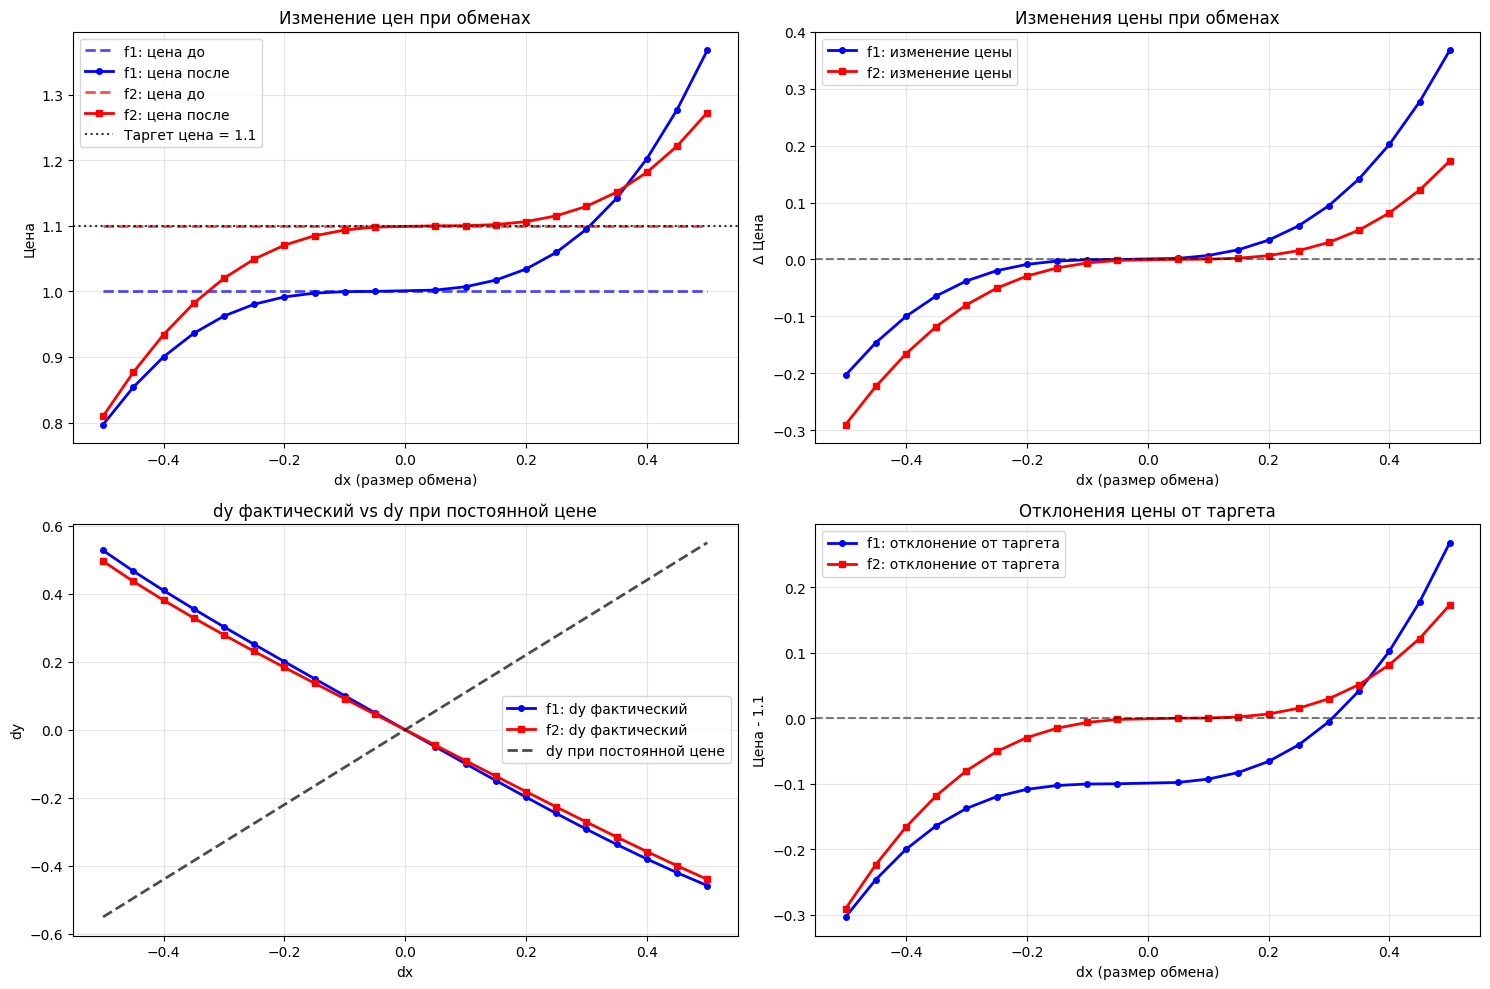

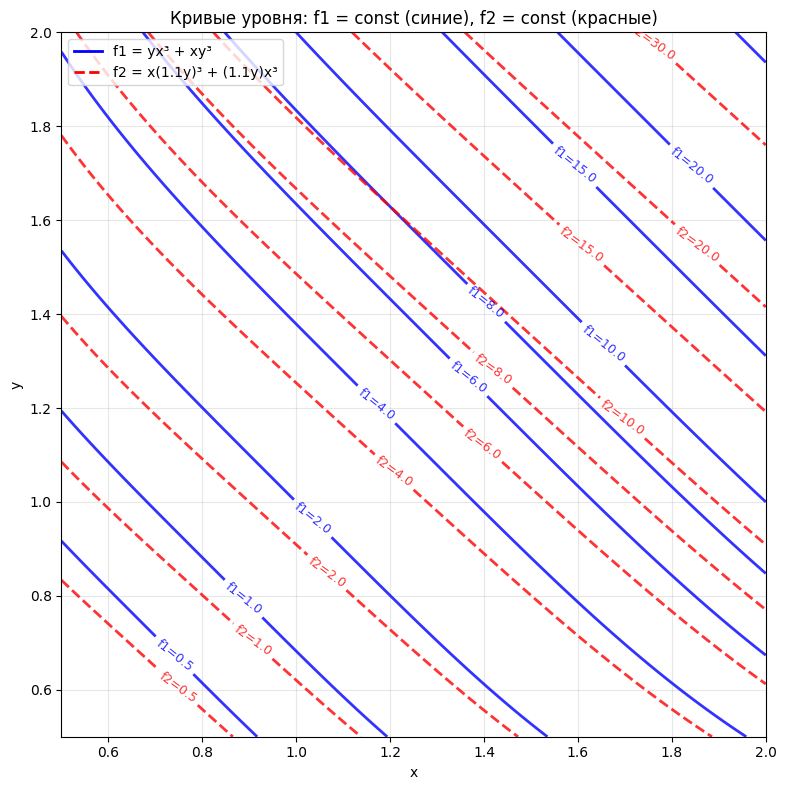

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison():
    """Визуализация анализа AMM кривых и изменения цен"""
    
    # Создаем компаратор
    comparator = FunctionComparator(f1, f2, f1_dx, f1_dy, f2_dx, f2_dy, target_price=1.1)
    
    # Получаем данные для графиков
    results, _, _ = comparator.compare_dy_range(dx_start=-0.5, dx_end=0.5, dx_step=0.05)
    sensitivity, _, _ = comparator.sensitivity_analysis(dx_values=np.linspace(-0.5, 0.5, 21))
    
    # Извлекаем данные
    dx_vals = [r['dx'] for r in results]
    dy1_vals = [r['dy1'] for r in results]
    dy2_vals = [r['dy2'] for r in results]
    target_dy_vals = [r['target_dy'] for r in results]
    price1_before = [r['price1_before'] for r in results]
    price1_after = [r['price1_after'] for r in results]
    price2_before = [r['price2_before'] for r in results]
    price2_after = [r['price2_after'] for r in results]
    price1_changes = [r['price1_change'] for r in results]
    price2_changes = [r['price2_change'] for r in results]
    
    # Создаем фигуру с подграфиками
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # График 1: Цены до и после обмена
    ax1.plot(dx_vals, price1_before, 'b--', label='f1: цена до', linewidth=2, alpha=0.7)
    ax1.plot(dx_vals, price1_after, 'b-', label='f1: цена после', linewidth=2, marker='o', markersize=4)
    ax1.plot(dx_vals, price2_before, 'r--', label='f2: цена до', linewidth=2, alpha=0.7)
    ax1.plot(dx_vals, price2_after, 'r-', label='f2: цена после', linewidth=2, marker='s', markersize=4)
    ax1.axhline(y=1.1, color='k', linestyle=':', alpha=0.8, label='Таргет цена = 1.1')
    ax1.set_xlabel('dx (размер обмена)')
    ax1.set_ylabel('Цена')
    ax1.set_title('Изменение цен при обменах')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Изменения цены
    ax2.plot(dx_vals, price1_changes, 'b-', label='f1: изменение цены', linewidth=2, marker='o', markersize=4)
    ax2.plot(dx_vals, price2_changes, 'r-', label='f2: изменение цены', linewidth=2, marker='s', markersize=4)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.set_xlabel('dx (размер обмена)')
    ax2.set_ylabel('Δ Цена')
    ax2.set_title('Изменения цены при обменах')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: dy vs target_dy
    ax3.plot(dx_vals, dy1_vals, 'b-', label='f1: dy фактический', linewidth=2, marker='o', markersize=4)
    ax3.plot(dx_vals, dy2_vals, 'r-', label='f2: dy фактический', linewidth=2, marker='s', markersize=4)
    ax3.plot(dx_vals, target_dy_vals, 'k--', label='dy при постоянной цене', linewidth=2, alpha=0.7)
    ax3.set_xlabel('dx')
    ax3.set_ylabel('dy')
    ax3.set_title('dy фактический vs dy при постоянной цене')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # График 4: Отклонения цены от таргета
    price1_deviations = [p - 1.1 for p in price1_after]
    price2_deviations = [p - 1.1 for p in price2_after]
    ax4.plot(dx_vals, price1_deviations, 'b-', label='f1: отклонение от таргета', linewidth=2, marker='o', markersize=4)
    ax4.plot(dx_vals, price2_deviations, 'r-', label='f2: отклонение от таргета', linewidth=2, marker='s', markersize=4)
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax4.set_xlabel('dx (размер обмена)')
    ax4.set_ylabel('Цена - 1.1')
    ax4.set_title('Отклонения цены от таргета')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Дополнительный график: Кривые уровня f1=const и f2=const
    fig2, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Создаем сетку для кривых уровня
    x_range = np.linspace(0.5, 2.0, 200)
    y_range = np.linspace(0.5, 2.0, 200)
    X, Y = np.meshgrid(x_range, y_range)
    Z1 = f1(X, Y)
    Z2 = f2(X, Y)
    
    # Определяем уровни для кривых
    levels = [0.5, 1, 2, 4, 6, 8, 10, 15, 20, 30]
    
    # Строим кривые уровня для f1
    contours1 = ax.contour(X, Y, Z1, levels=levels, colors='blue', linewidths=2, alpha=0.8)
    ax.clabel(contours1, inline=True, fontsize=9, fmt='f1=%.1f')
    
    # Строим кривые уровня для f2  
    contours2 = ax.contour(X, Y, Z2, levels=levels, colors='red', linewidths=2, alpha=0.8, linestyles='dashed')
    ax.clabel(contours2, inline=True, fontsize=9, fmt='f2=%.1f')
    
    # Создаем легенду
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='blue', linewidth=2, label='f1 = yx³ + xy³'),
                      Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='f2 = x(1.1y)³ + (1.1y)x³')]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Кривые уровня: f1 = const (синие), f2 = const (красные)')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    return results, sensitivity

# Создаем графики
plot_results, plot_sensitivity = plot_comparison()


In [37]:
x = 3690
y = 1860

fc = FunctionComparator(f1, f2, f1_dx, f1_dy, f2_dx, f2_dy, target_price=1.1)

print(fc.get_price(f1_dx, f1_dy, x, y))

1.074363386300659
